In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [191]:
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate

In [192]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [193]:
print("torch:", torch.__version__)
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE 

torch: 2.10.0+cu128


'cuda'

In [194]:
df = pd.read_csv("./data/nepsealpha_export_price_NTC_2021-01-03_2026-01-03_unadjusted.csv", encoding="latin1")
df.head()

,Symbol,Date,Open,High,Low,Close,Percent Change,Volume,Turn Over
0,NTC,2026-01-01,905.0,909.0,902.2,905.0,0.00 %,"74,592.00","67,568,456.30"
1,NTC,2025-12-31,909.0,909.0,900.0,905.0,0.02 %,"40,304.00","36,498,409.60"
2,NTC,2025-12-29,908.0,911.0,898.0,904.8,-0.13 %,"38,244.00","34,636,425.70"
3,NTC,2025-12-28,909.9,909.9,896.0,906.0,1.18 %,"38,661.00","34,912,329.80"
4,NTC,2025-12-24,916.9,916.9,890.0,895.4,-0.40 %,"39,968.00","35,856,692.70"


In [195]:
df['Date'] = pd.to_datetime(df['Date'])

In [196]:
# df.drop("Percent Change",axis=1,inplace=True)
# df.drop("Volume",axis=1,inplace=True)
df.drop("Symbol",axis=1,inplace=True)
df.drop("Turn Over",axis=1,inplace=True)

In [197]:
df['Percent Change'] = df['Percent Change'].str.replace('%', '').astype(float) / 100
df['price_change'] = df['Percent Change'] * df['Close']

In [198]:
df['price_change'] = df['price_change'].round(1)
df.drop("Percent Change",axis=1,inplace=True)

In [199]:
df.head()

,Date,Open,High,Low,Close,Volume,price_change
0,2026-01-01,905.0,909.0,902.2,905.0,"74,592.00",0.0
1,2025-12-31,909.0,909.0,900.0,905.0,"40,304.00",0.2
2,2025-12-29,908.0,911.0,898.0,904.8,"38,244.00",-1.2
3,2025-12-28,909.9,909.9,896.0,906.0,"38,661.00",10.7
4,2025-12-24,916.9,916.9,890.0,895.4,"39,968.00",-3.6


In [200]:
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False)
df['Volume'] = df['Volume'].replace('-', 0) # Replace hyphens with NaN
df['Volume'] = pd.to_numeric(df['Volume'])

In [201]:
df

,Date,Open,High,Low,Close,Volume,price_change
0,2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0
1,2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2
2,2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2
3,2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7
4,2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6
...,...,...,...,...,...,...,...
1161,2021-01-07,1282.0,1295.0,1263.0,1268.0,0.0,-0.3
1162,2021-01-06,1300.0,1300.0,1277.0,1288.0,0.0,0.1
1163,2021-01-05,1250.0,1306.0,1250.0,1275.0,0.0,-0.1
1164,2021-01-04,1320.0,1346.0,1270.0,1291.0,0.0,-0.1


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.9 KB


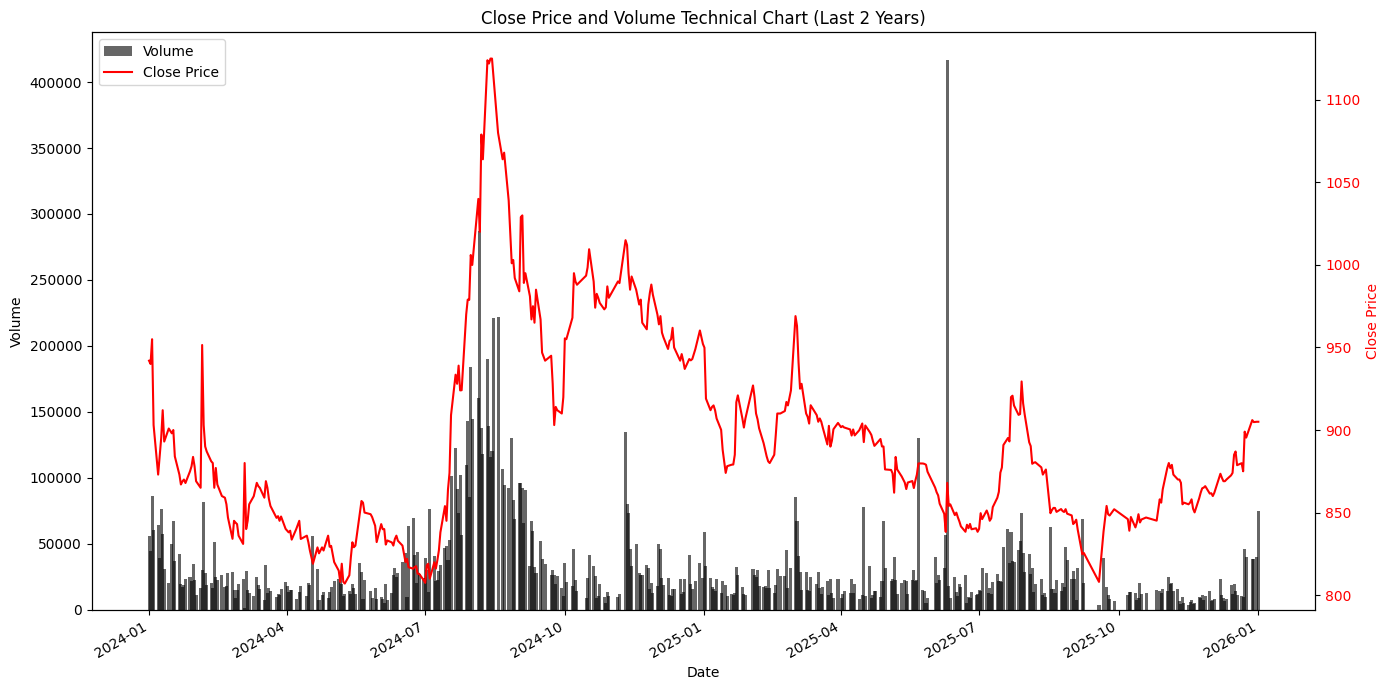

In [203]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Date
df_sorted = df.sort_values(by='Date').copy()

# Filter for the last 2 years of data
end_date = df_sorted['Date'].max()
start_date = end_date - pd.DateOffset(years=2)
df_filtered = df_sorted[(df_sorted['Date'] >= start_date) & (df_sorted['Date'] <= end_date)]

# Create figure and primary axes for Volume
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Volume as a bar chart on ax1
ax1.bar(df_filtered['Date'], df_filtered['Volume'], color='black', alpha=0.6, label='Volume', width=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for Close price
ax2 = ax1.twinx()

# Plot Close price as a line chart on ax2
ax2.plot(df_filtered['Date'], df_filtered['Close'], color='red', label='Close Price')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set chart title and legends
plt.title('Close Price and Volume Technical Chart (Last 2 Years)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [204]:
df_long = df.melt(
    id_vars=["Date"],
    value_vars=["Open", "High", "Low", "Close","Volume","price_change"],
    var_name="unique_id",
    value_name="y"
).rename(columns={"Date": "ds"})

In [205]:
df_long.head()

,ds,unique_id,y
0,2026-01-01,Open,905.0
1,2025-12-31,Open,909.0
2,2025-12-29,Open,908.0
3,2025-12-28,Open,909.9
4,2025-12-24,Open,916.9


In [206]:
df_long = (
    df_long
    .groupby(['ds', 'unique_id'], as_index=False)['y']
    .mean()
)


In [207]:
df_long

,ds,unique_id,y
0,2021-01-03,Close,1302.0
1,2021-01-03,High,1304.0
2,2021-01-03,Low,1225.0
3,2021-01-03,Open,1235.0
4,2021-01-03,Volume,0.0
...,...,...,...
6991,2026-01-01,High,909.0
6992,2026-01-01,Low,902.2
6993,2026-01-01,Open,905.0
6994,2026-01-01,Volume,74592.0


In [208]:
df_long.info

<bound method DataFrame.info of              ds     unique_id        y
0    2021-01-03         Close   1302.0
1    2021-01-03          High   1304.0
2    2021-01-03           Low   1225.0
3    2021-01-03          Open   1235.0
4    2021-01-03        Volume      0.0
...         ...           ...      ...
6991 2026-01-01          High    909.0
6992 2026-01-01           Low    902.2
6993 2026-01-01          Open    905.0
6994 2026-01-01        Volume  74592.0
6995 2026-01-01  price_change      0.0

[6996 rows x 3 columns]>

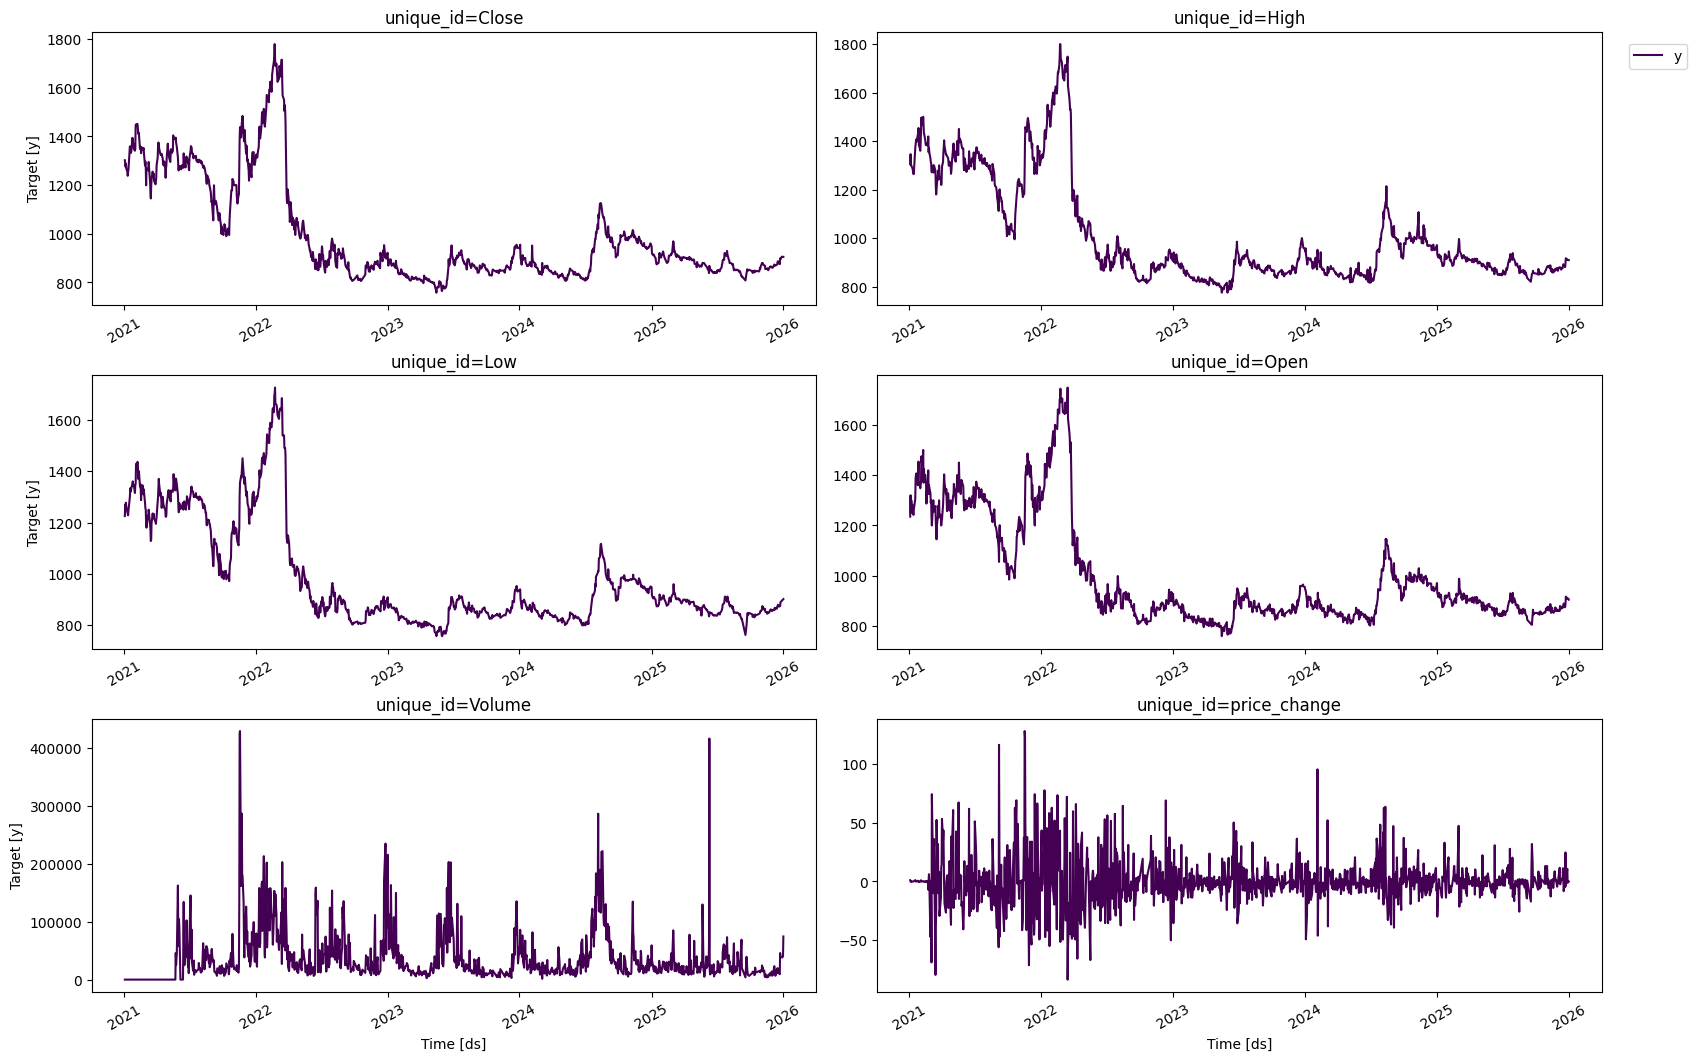

In [209]:
plot_series(df=df_long, palette="viridis")

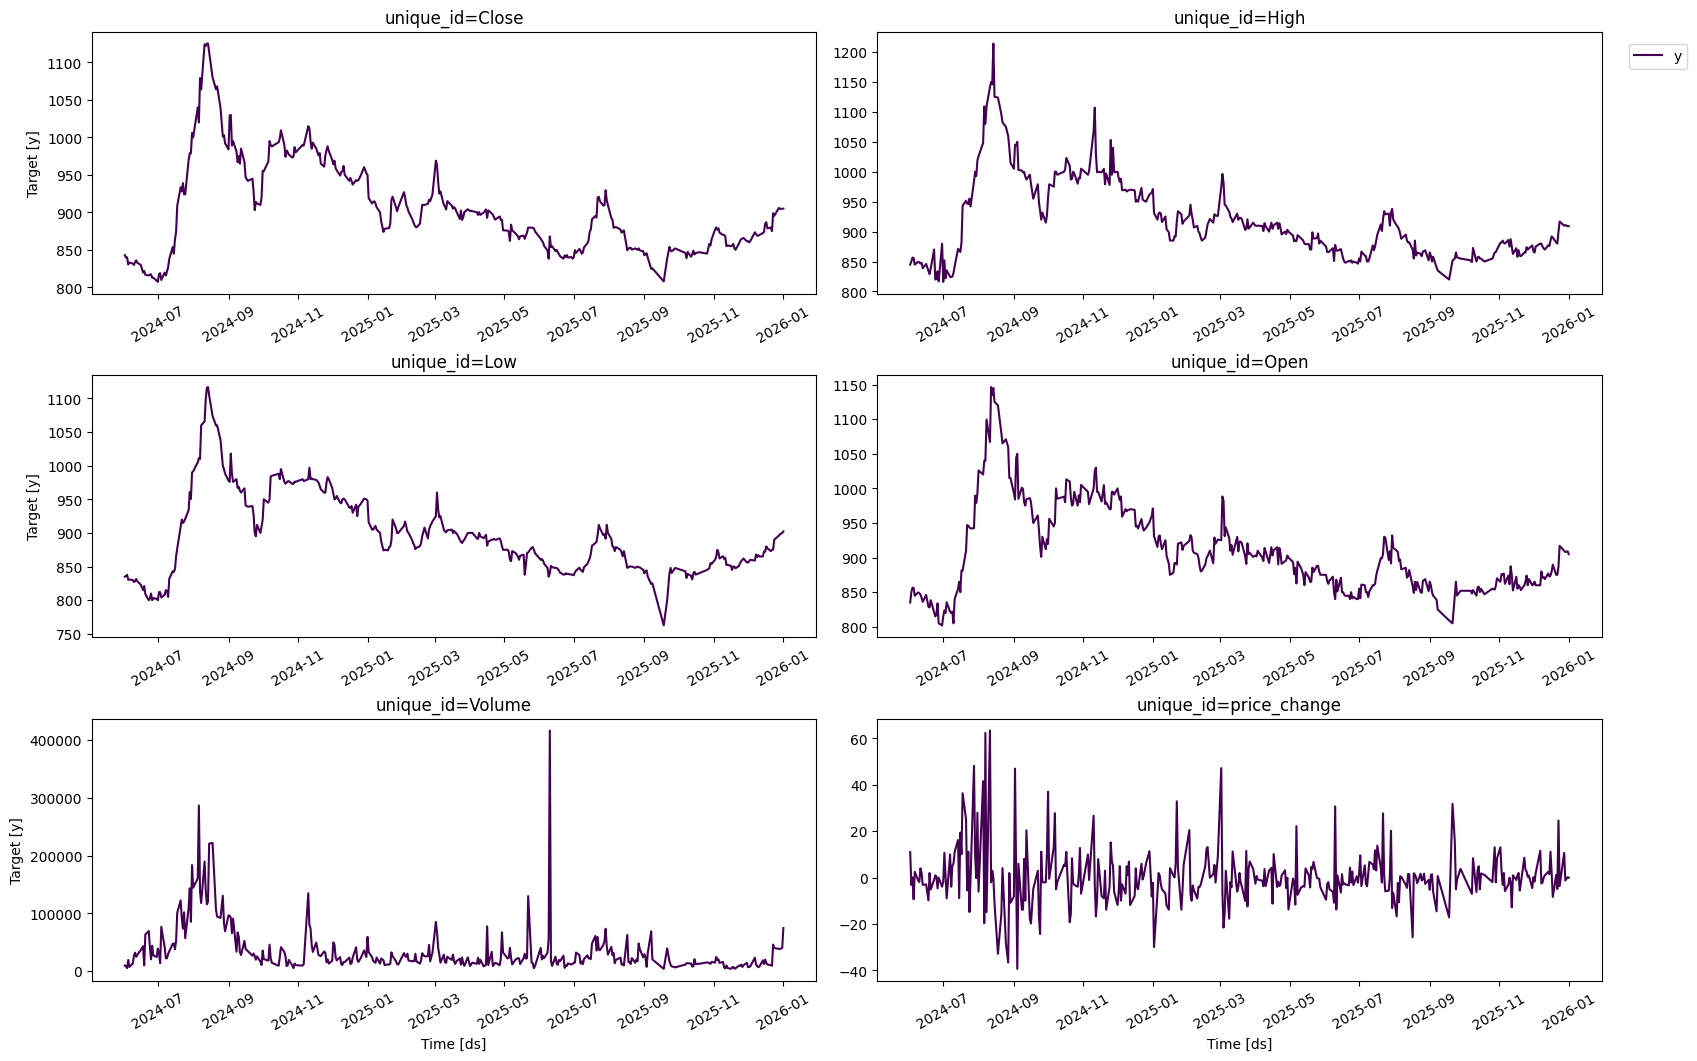

In [210]:
plot_series(df=df_long, max_insample_length=30*12, palette="viridis")

Time Series Decomposition

In [211]:
from statsmodels.tsa.seasonal import seasonal_decompose

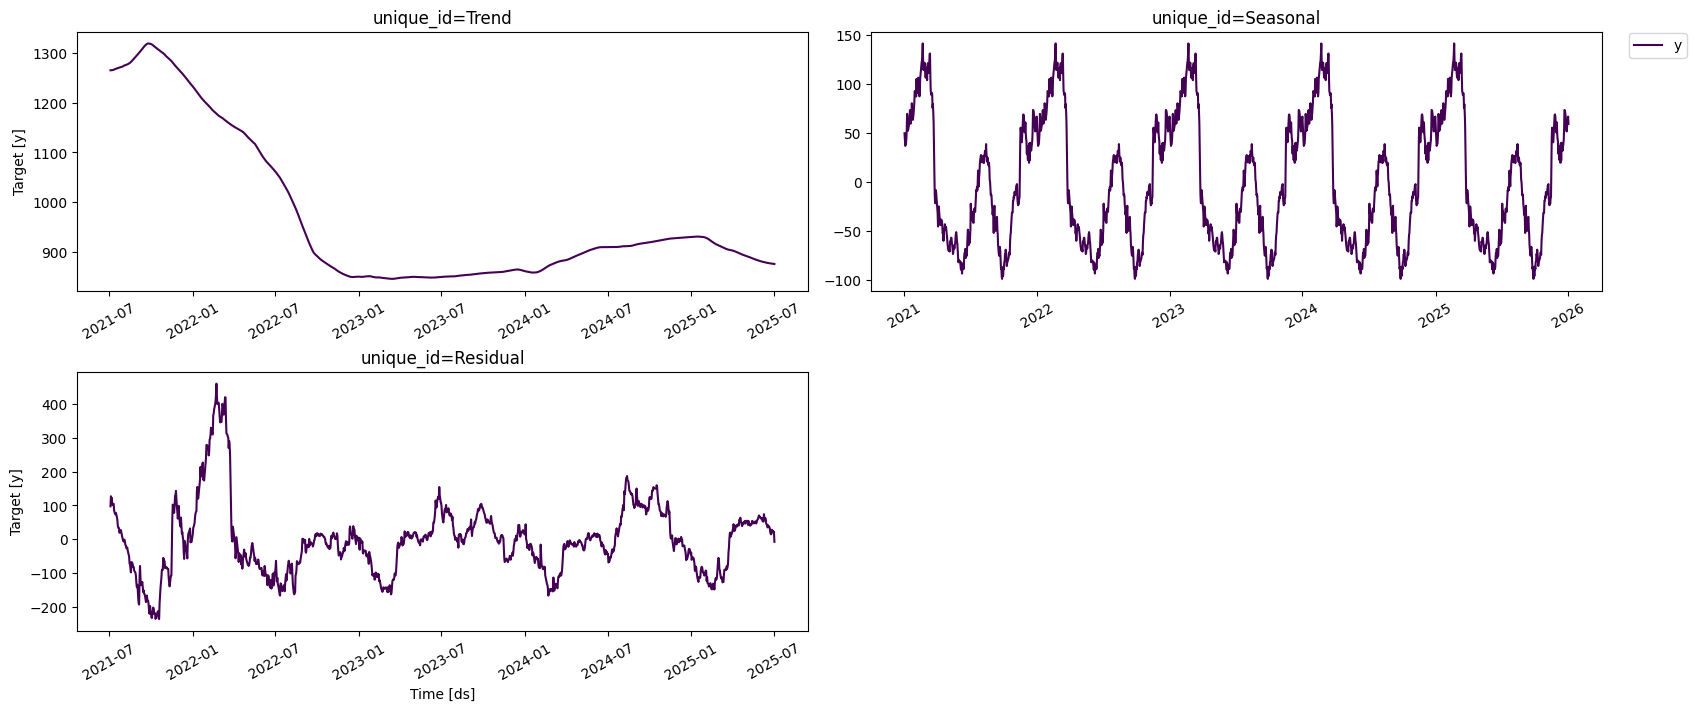

In [212]:
var = "Close"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

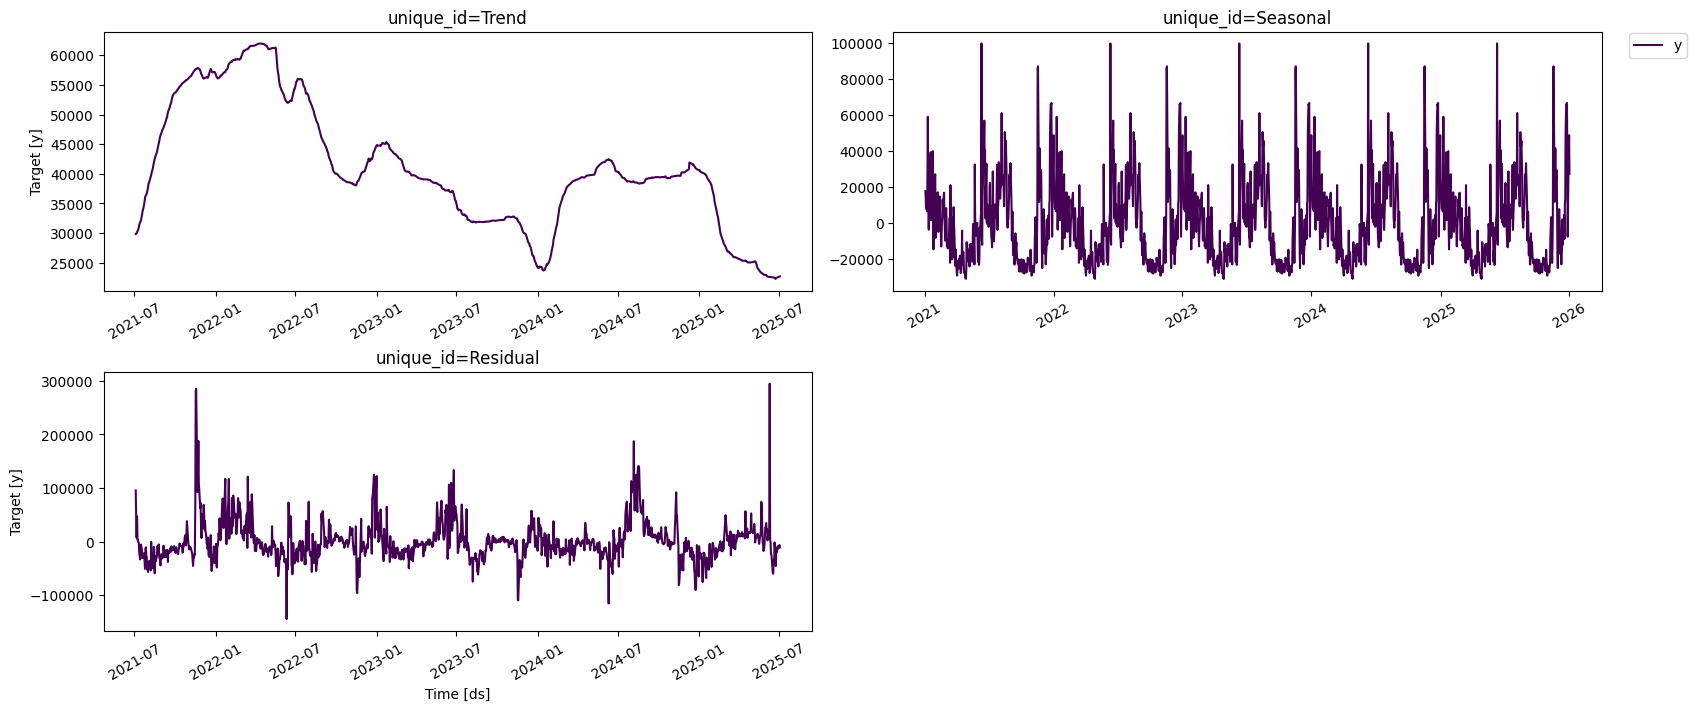

In [213]:
var = "Volume"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D")
    .interpolate(method="linear")
)

result = seasonal_decompose(ts, model="additive", period=365)

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365,
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

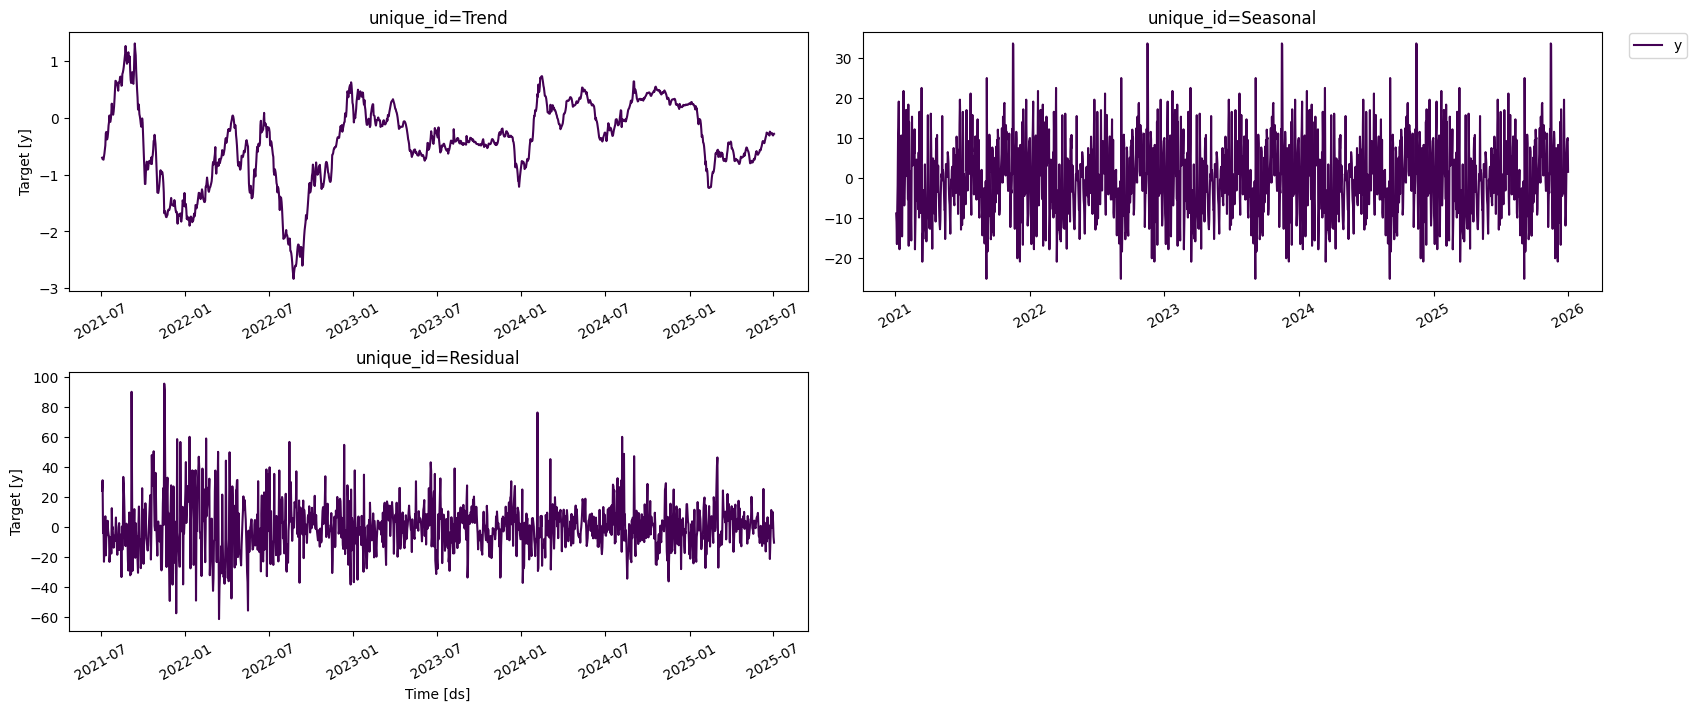

In [214]:
var = "price_change"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

In [215]:
df.head()

,Date,Open,High,Low,Close,Volume,price_change
0,2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0
1,2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2
2,2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2
3,2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7
4,2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.9 KB


In [217]:
df.index = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [218]:
df.head()

,Date,Open,High,Low,Close,Volume,price_change
Date,,,,,,,
2026-01-01,2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0
2025-12-31,2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2
2025-12-29,2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2
2025-12-28,2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7
2025-12-24,2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6


In [219]:
df['Date'] = pd.to_datetime(df['Date'])

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2026-01-01 to 2021-01-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 72.9 KB


In [221]:
df.drop("Date",axis=1,inplace=True)


In [222]:
df.dropna(inplace=True)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2026-01-01 to 2021-01-03
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1166 non-null   float64
 1   High          1166 non-null   float64
 2   Low           1166 non-null   float64
 3   Close         1166 non-null   float64
 4   Volume        1166 non-null   float64
 5   price_change  1166 non-null   float64
dtypes: float64(6)
memory usage: 63.8 KB


In [224]:
def calculate_technical_indicators(df):
    # Calculate RSI
    def RSI(series, period):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        RS = gain / loss
        return 100 - (100 / (1 + RS))
    df['momentum_rsi'] = RSI(df['Close'],14)
    
    # Calculate SMA
    df['trend_sma_fast'] = df['Close'].rolling(window=10).mean()
    
    # Calculate WMA
    weights = np.arange(1, 11)
    df['wma'] = df['Close'].rolling(10).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Calculate Momentum
    df['momentum'] = df['Close'].diff(10)
    
    # Calculate MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['trend_macd'] = df['EMA12'] - df['EMA26']
    
    # Calculate Stochastic Oscillator K% and D%
    low_min = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['stoch_k'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Calculate William's %R
    df['momentum_wr'] = -100 * (high_max - df['Close']) / (high_max - low_min)
    
    # Calculate CCI
    TP = (df['Close'] + df['High'] + df['Low']) / 3
    df['trend_cci'] = (TP - TP.rolling(window=20).mean()) / (0.015 * TP.rolling(window=20).std())
    
    # Calculate A/D Oscillator
    df['volume_adi'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    
    # Calculate HMA
    def WMA(series, window):
        weights = np.arange(1, window + 1)
        return series.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    def HMA(series, window):
        half_length = int(window / 2)
        sqrt_length = int(np.sqrt(window))
        WMA_half = WMA(series, half_length)
        WMA_full = WMA(series, window)
        HMA = WMA(2 * WMA_half - WMA_full, sqrt_length)
        return HMA
    
    df['hma'] = HMA(df['Close'], 10)
    
    return df

# Calculate technical indicators
dataframe = calculate_technical_indicators(df)

# Display the first few rows with technical indicators
dataframe

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,EMA12,EMA26,trend_macd,stoch_k,stoch_d,momentum_wr,trend_cci,volume_adi,hma
Date,,,,,,,,,,,,,,,,,,,
2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0,NaN,NaN,NaN,NaN,905.000000,905.000000,0.000000,NaN,NaN,NaN,NaN,-0.176471,NaN
2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2,NaN,NaN,NaN,NaN,905.000000,905.000000,0.000000,NaN,NaN,NaN,NaN,0.111111,NaN
2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2,NaN,NaN,NaN,NaN,904.969231,904.985185,-0.015954,NaN,NaN,NaN,NaN,0.046154,NaN
2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7,NaN,NaN,NaN,NaN,905.127811,905.060357,0.067454,NaN,NaN,NaN,NaN,0.438849,NaN
2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6,NaN,NaN,NaN,NaN,903.631224,904.344775,-0.713550,NaN,NaN,NaN,NaN,-0.598513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07,1282.0,1295.0,1263.0,1268.0,0.0,-0.3,37.012987,1300.2,1281.145455,-126.0,1302.154631,1326.547745,-24.393114,17.699115,11.356932,-82.300885,-78.068195,-0.687500,1231.169697
2021-01-06,1300.0,1300.0,1277.0,1288.0,0.0,0.1,36.393443,1295.0,1278.927273,-52.0,1299.976996,1323.692357,-23.715361,26.548673,18.731563,-73.451327,-58.618604,-0.043478,1242.494949
2021-01-05,1250.0,1306.0,1250.0,1275.0,0.0,-0.1,36.156352,1289.3,1275.290909,-57.0,1296.134381,1320.085516,-23.951135,23.857868,22.701885,-76.142132,-67.292947,-0.107143,1257.898990


In [225]:
dataframe.dropna(inplace=True)
dataframe

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,EMA12,EMA26,trend_macd,stoch_k,stoch_d,momentum_wr,trend_cci,volume_adi,hma
Date,,,,,,,,,,,,,,,,,,,
2025-12-02,865.0,865.0,858.1,860.0,7090.0,-1.7,23.790323,870.60,867.863636,-27.0,872.720464,882.556082,-9.835618,5.604720,12.654990,-94.395280,-94.089608,-0.449275,865.045354
2025-12-01,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,871.025008,881.011187,-9.986179,15.833333,9.585042,-84.166667,-84.222172,0.036364,862.331313
2025-11-30,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,869.559622,879.565914,-10.006292,15.277778,12.238610,-84.722222,-63.857124,-0.476190,860.320303
2025-11-27,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,869.011988,878.561032,-9.549044,27.777778,19.629630,-72.222222,-50.757315,-0.191919,860.326364
2025-11-26,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,868.410144,877.563918,-9.153775,31.379310,24.811622,-68.620690,-57.259683,0.020000,861.704343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07,1282.0,1295.0,1263.0,1268.0,0.0,-0.3,37.012987,1300.20,1281.145455,-126.0,1302.154631,1326.547745,-24.393114,17.699115,11.356932,-82.300885,-78.068195,-0.687500,1231.169697
2021-01-06,1300.0,1300.0,1277.0,1288.0,0.0,0.1,36.393443,1295.00,1278.927273,-52.0,1299.976996,1323.692357,-23.715361,26.548673,18.731563,-73.451327,-58.618604,-0.043478,1242.494949
2021-01-05,1250.0,1306.0,1250.0,1275.0,0.0,-0.1,36.156352,1289.30,1275.290909,-57.0,1296.134381,1320.085516,-23.951135,23.857868,22.701885,-76.142132,-67.292947,-0.107143,1257.898990


In [226]:
def process_indicators(df:pd.DataFrame, close:str, sma:str, wma:str, stK:str, stD:str, will:str, macd:str, rsi:str, cci:str, ad:str, momentum:str)->pd.DataFrame:
    pr_sma = []
    pr_wma = []
    pr_stK = []
    pr_stD = []
    pr_will = []
    pr_macd = []
    pr_rsi = []
    pr_cci = []
    pr_ad = []
    pr_moment = []
    prev_row = df.iloc[0]
    for i in range(0, len(df.index)):
        row = df.iloc[i]
        prev_close = prev_row[close]
        r_close = row[close]
        # SMA
        if r_close > row[sma]:
            pr_sma.append(1)
        else:
            pr_sma.append(-1)

        # WMA
        if r_close > row[wma]:
            pr_wma.append(1)
        else:
            pr_wma.append(-1)

        # stochasticK
        if row[stK] > prev_row[stK]:
            pr_stK.append(1)
        else:
            pr_stK.append(-1)
        
        # stochasticD
        if row[stD] > prev_row[stD]:
            pr_stD.append(1)
        else:
            pr_stD.append(-1)
        
        # William's oscillator
        if row[will] > prev_row[will]:
            pr_will.append(1)
        else:
            pr_will.append(-1)
        
        # MACD
        if row[macd] > prev_row[macd]:
            pr_macd.append(1)
        else:
            pr_macd.append(-1)
        
        # RSI
        if row[rsi] > 70:
            pr_rsi.append(-1)
        elif row[rsi] < 30:
            pr_rsi.append(1)
        else:
            if row[rsi] > prev_row[rsi]:
                pr_rsi.append(1)
            else:
                pr_rsi.append(-1)
        
        # cci
        if row[cci] > 200:
            pr_cci.append(-1)
        elif row[cci] < 200:
            pr_cci.append(1)
        else:
            if row[cci] > prev_row[cci]:
                pr_cci.append(1)
            else:
                pr_cci.append(-1)
        
        # A/D oscillator
        if row[ad] > prev_row[ad]:
            pr_ad.append(1)
        else:
            pr_ad.append(-1)
        
        # Momentum
        if row[momentum] >= 0:
            pr_moment.append(1)
        else:
            pr_moment.append(-1)
    
        prev_row = row
    
    df["pr_sma"] = pr_sma
    df["pr_wma"] = pr_wma
    df["pr_stK"] = pr_stK
    df["pr_stD"] = pr_stD
    df["pr_will"] = pr_will
    df["pr_macd"] = pr_macd
    df["pr_rsi"] = pr_rsi
    df["pr_cci"] = pr_cci
    df["pr_ad"] = pr_ad
    df["pr_moment"] = pr_moment

    # df = df.drop([sma, wma, stK, stD, will, macd, rsi, cci, ad, momentum], axis=1)

    return df

In [227]:
dataframe = process_indicators(dataframe,
                "Close",
                "trend_sma_fast",
                "wma",
                "stoch_k",
                "stoch_d",
                "momentum_wr",
                "trend_macd",
                "momentum_rsi",
                "trend_cci",
                "volume_adi",
                "momentum"
                )

In [228]:
dataframe.head()

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_sma,pr_wma,pr_stK,pr_stD,pr_will,pr_macd,pr_rsi,pr_cci,pr_ad,pr_moment
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-02,865.0,865.0,858.1,860.0,7090.0,-1.7,23.790323,870.60,867.863636,-27.0,...,-1,-1,-1,-1,-1,-1,1,1,-1,-1
2025-12-01,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,...,-1,-1,1,-1,1,-1,1,1,1,-1
2025-11-30,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,...,-1,-1,-1,1,-1,-1,-1,1,-1,-1
2025-11-27,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,...,-1,1,1,1,1,1,1,1,1,-1
2025-11-26,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,...,-1,1,1,1,1,1,1,1,1,-1


In [229]:
def prepare_trend_array(df):
    trend_arr = []
    close_vals = df[["Close"]].values
    if len(close_vals) == 0:
        return trend_arr

    pre_val = close_vals[0]
    hh_val = pre_val
    hl_val = pre_val

    # HH, HL= 1,2 / LH, LL = 3,4 / Neut = 0

    trend_arr.append(0)
    for i in range(1, len(close_vals)):
        cur_val = close_vals[i]
        # high
        if cur_val > pre_val:
            # HH
            if cur_val >= hh_val:
                trend_arr.append(1)
                hh_val = cur_val
            # LH
            else:
                trend_arr.append(3)

        # low
        elif cur_val < pre_val:
            # HL
            if cur_val >= hl_val:
                trend_arr.append(2)
                hl_val = cur_val
            # LL
            else:
                trend_arr.append(4)

        # neut
        else:
            trend_arr.append(0)
        
        pre_val = cur_val

    if len(trend_arr) > 0:
        val = trend_arr[1]
        if val == 1 or val == 3:
            # label first value as HH
            trend_arr[0] = 1
        elif val == 2 or val == 4:
            # label first value as HL
            trend_arr[0] = 2
    
    return trend_arr

def add_trend_columns(df: pd.DataFrame, close: str):
    hh_arr = []
    hl_arr = []
    lh_arr = []
    trend_arr = prepare_trend_array(df)

    index = 0
    for i in trend_arr:
        if i == 1:
            hh_arr.append(1)
            hl_arr.append(0)
            lh_arr.append(0)
        elif i==2:
            hh_arr.append(0)
            hl_arr.append(1)
            lh_arr.append(0)
        elif i == 3:
            hh_arr.append(0)
            hl_arr.append(0)
            lh_arr.append(1)
        elif i == 4:
            hh_arr.append(0)
            hl_arr.append(0)
            lh_arr.append(0)
        else:
            if index != 0:
                hh_arr.append(hh_arr[index-1])
                hl_arr.append(hl_arr[index-1])
                lh_arr.append(lh_arr[index-1])
            else:
                hh_arr.append(0)
                hl_arr.append(0)
                lh_arr.append(0)
        
        index += 1

    # label the first element(s) -> HL or HH
    if len(trend_arr) > 1:
        val = trend_arr[1]
        if val == 1 or val == 3:
            # label first value as HH
            hh_arr[0] = 1
        elif val == 2 or val == 4:
            # label first value as HL
            hl_arr[0] = 1

    df["trend_hh"] = np.array(hh_arr)
    df["trend_hl"] = np.array(hl_arr)
    df["trend_lh"] = np.array(lh_arr)  

    return df    

In [230]:
dataframe = add_trend_columns(dataframe, "Close")

In [547]:
dataframe.head()

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_stD,pr_will,pr_macd,pr_rsi,pr_cci,pr_ad,pr_moment,trend_hh,trend_hl,trend_lh
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-02,865.0,865.0,858.1,860.0,7090.0,-1.7,23.790323,870.60,867.863636,-27.0,...,-1,-1,-1,1,1,-1,-1,1,0,0
2025-12-01,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,...,-1,1,-1,1,1,1,-1,1,0,0
2025-11-30,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,...,1,-1,-1,-1,1,-1,-1,0,1,0
2025-11-27,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,...,1,1,1,1,1,1,-1,1,0,0
2025-11-26,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,...,1,1,1,1,1,1,-1,0,1,0


In [232]:
def add_stop_price(df: pd.DataFrame, trade_window: int = 10, alpha: float = 0.0001) -> pd.DataFrame:
    df = df.copy().reset_index(drop=True)
    close_vals = df["Close"].to_numpy(dtype=np.float64)
    n = len(close_vals)
    out = np.empty(n, dtype=np.float64)

    n_full = n // trade_window
    for w in range(n_full):
        s = w * trade_window
        e = s + trade_window
        win = close_vals[s:e].copy()
        max_i = int(np.argmax(win))

        win = win * (1.0 - alpha)                     # reduce all
        win[max_i] = close_vals[s+max_i] * (1.0 + alpha)  # boost best
        out[s:e] = win

    tail = n_full * trade_window
    if tail < n:
        out[tail:] = close_vals[tail:] * (1.0 - alpha)

    df["stop_price"] = out
    return df


In [428]:
def add_trend(df: pd.DataFrame, close_col="Close") -> pd.DataFrame:
    df = df.copy()
    df["trend"] = df[close_col].diff()
    # df = df.dropna().reset_index(drop=True)
    # df["trend_bin"] = (df["trend"] > 0).astype(np.float32)
    H = 5  # 5-step direction is less noisy than 1-step (good for minute data)
    delta = df["Close"].shift(-H) - df["Close"]
    eps = 1e-6
    df["trend_bin"] = (delta > eps).astype(np.float32)
    df = df.dropna().reset_index(drop=True)
    return df


In [514]:
LOOKBACK = 7
TRADE_WINDOW = 10
ALPHA = 0.0001        # paper value (0.01%)
BUFFER = 0.25         # 25% scaling buffer (paper code)

BATCH_SIZE = 64
LR = 3e-4

EPOCHS_TREND = 100
EPOCHS_PRICE = 100
EPOCHS_STOP  = 100
LAMBDA_DIR   = 0.5    # directional penalty weight

In [515]:
df = dataframe.copy()

df = add_trend(df, "Close")
df = add_stop_price(df, TRADE_WINDOW, ALPHA)

print(df.shape)
display(df.head())



(1146, 35)


,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_rsi,pr_cci,pr_ad,pr_moment,trend_hh,trend_hl,trend_lh,trend,trend_bin,stop_price
0,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,...,1,1,1,-1,1,0,0,1.7,1.0,861.61383
1,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,...,-1,1,-1,-1,0,1,0,-0.2,0.0,861.41385
2,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,...,1,1,1,-1,1,0,0,4.5,0.0,866.08660
3,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,...,1,1,1,-1,0,1,0,-0.9,0.0,865.01349
4,874.0,874.0,858.0,864.7,11152.0,2.7,25.659472,865.45,864.383636,-4.3,...,1,1,-1,-1,0,0,0,-0.4,0.0,864.61353


In [548]:
df.head()

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_rsi,pr_cci,pr_ad,pr_moment,trend_hh,trend_hl,trend_lh,trend,trend_bin,stop_price
0,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,...,1,1,1,-1,1,0,0,1.7,1.0,861.61383
1,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,...,-1,1,-1,-1,0,1,0,-0.2,0.0,861.41385
2,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,...,1,1,1,-1,1,0,0,4.5,0.0,866.08660
3,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,...,1,1,1,-1,0,1,0,-0.9,0.0,865.01349
4,874.0,874.0,858.0,864.7,11152.0,2.7,25.659472,865.45,864.383636,-4.3,...,1,1,-1,-1,0,0,0,-0.4,0.0,864.61353


In [516]:
# Discretized trend indicators
trend_disc_cols = [c for c in df.columns if c.startswith("pr_")]
trend_disc_cols += [c for c in ["trend_hh", "trend_hl", "trend_lh"] if c in df.columns]

# Continuous price features
exclude = {"trend", "trend_bin"}
price_cols = [c for c in df.columns if c not in exclude and not c.startswith("pr_")]

print("Trend cols:", trend_disc_cols)
print("Price cols:", price_cols)


Trend cols: ['pr_sma', 'pr_wma', 'pr_stK', 'pr_stD', 'pr_will', 'pr_macd', 'pr_rsi', 'pr_cci', 'pr_ad', 'pr_moment', 'trend_hh', 'trend_hl', 'trend_lh']
Price cols: ['Open', 'High', 'Low', 'Close', 'Volume', 'price_change', 'momentum_rsi', 'trend_sma_fast', 'wma', 'momentum', 'EMA12', 'EMA26', 'trend_macd', 'stoch_k', 'stoch_d', 'momentum_wr', 'trend_cci', 'volume_adi', 'hma', 'trend_hh', 'trend_hl', 'trend_lh', 'stop_price']


In [517]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

In [518]:
def fit_paper_scaler(df, buffer=0.25):
    values = df.values.astype(np.float64).copy()
    max_vals = values.max(axis=0)
    min_vals = values.min(axis=0)

    max_idx = values.argmax(axis=0)
    min_idx = values.argmin(axis=0)

    for j in range(values.shape[1]):
        values[max_idx[j], j] = max_vals[j] * (1 + buffer)
        values[min_idx[j], j] = min_vals[j] * (1 - buffer)

    scaler = MinMaxScaler()
    scaler.fit(values)
    return scaler


scale_cols = df.columns.tolist()
scaler = fit_paper_scaler(df[scale_cols], BUFFER)

df_scaled = df.copy()
df_scaled[scale_cols] = scaler.transform(df[scale_cols])

display(df_scaled.head())


/home/pukar/development/stop_loss_prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_rsi,pr_cci,pr_ad,pr_moment,trend_hh,trend_hl,trend_lh,trend,trend_bin,stop_price
0,0.180467,0.171249,0.181074,0.177133,0.012535,0.333020,0.281078,0.185081,0.182733,0.272734,...,0.888889,0.888889,0.888889,0.0,0.8,0.0,0.0,0.237932,0.8,0.177086
1,0.179539,0.177242,0.181074,0.177013,0.026128,0.313356,0.219692,0.184271,0.181944,0.283080,...,0.000000,0.888889,0.000000,0.0,0.0,0.8,0.0,0.233987,0.0,0.176965
2,0.185111,0.174185,0.184853,0.179731,0.019014,0.335948,0.283288,0.183850,0.181826,0.288828,...,0.888889,0.888889,0.888889,0.0,0.8,0.0,0.0,0.243745,0.0,0.179787
3,0.179539,0.173047,0.183593,0.179187,0.013484,0.333856,0.165382,0.183533,0.181678,0.290360,...,0.888889,0.888889,0.888889,0.0,0.0,0.8,0.0,0.232534,0.0,0.179139
4,0.188206,0.175444,0.182333,0.178946,0.020758,0.343479,0.174140,0.183255,0.181540,0.290935,...,0.888889,0.888889,0.000000,0.0,0.0,0.0,0.0,0.233572,0.0,0.178898


In [519]:
class MultiStreamDataset(Dataset):
    def __init__(self, df, trend_cols, price_cols, lookback):
        self.df = df.reset_index(drop=True)
        self.trend_cols = trend_cols
        self.price_cols = price_cols
        self.lookback = lookback

        self.Xt = df[trend_cols].values.astype(np.float32)
        self.Xp = df[price_cols].values.astype(np.float32)

        self.y_tr = df["trend_bin"].values.astype(np.float32)
        self.y_cl = df["Close"].values.astype(np.float32)
        self.y_st = df["stop_price"].values.astype(np.float32)

        self.n = len(df) - lookback - 1

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        t = idx + self.lookback
        return (
            torch.from_numpy(self.Xt[t-LOOKBACK:t]),
            torch.from_numpy(self.Xp[t-LOOKBACK:t]),
            torch.tensor(self.y_tr[t+1]),
            torch.tensor(self.y_cl[t+1]),
            torch.tensor(self.y_st[t+1])
        )


In [520]:
split = int(len(df_scaled) * 0.8)

df_train = df_scaled.iloc[:split].reset_index(drop=True)
df_val   = df_scaled.iloc[split:].reset_index(drop=True)

train_ds = MultiStreamDataset(df_train, trend_disc_cols, price_cols, LOOKBACK)
val_ds   = MultiStreamDataset(df_val, trend_disc_cols, price_cols, LOOKBACK)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


In [521]:
class ConvPoolHead(nn.Module):
    """
    Conv1D stack over time + global mean pool over time.
    Input:  (B, in_ch, T)
    Output: (B, out_ch)
    """
    def __init__(self, in_ch: int, c1: int, c2: int, kernel_size: int = 2, padding: int = 1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, c1, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(c1, c2, kernel_size=kernel_size, padding=padding)
        self.out_dim = c2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.mean(dim=2)  # global mean pool over time -> (B, c2)
        return x


In [522]:
class TemporalAttention(nn.Module):
    """
    Additive attention over time.
    Input:  enc_out (B, T, H)
    Output: context (B, H)
    """
    def __init__(self, hidden_size: int):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, enc_out):
        score = self.v(torch.tanh(self.W(enc_out))).squeeze(-1)  # (B,T)
        w = torch.softmax(score, dim=1)                          # (B,T)
        ctx = torch.sum(enc_out * w.unsqueeze(-1), dim=1)        # (B,H)
        return ctx


In [523]:
class PaperLSTMAttnCNNRegressor(nn.Module):
    """
    Paper-like backbone:
      LSTM encoder -> Attention context -> CNN decoder over time -> concat -> FC -> scalar

    This is mismatch-proof because:
      FC input dim = enc_hidden + conv_head.out_dim
    """
    def __init__(
        self,
        in_features: int,
        enc_hidden: int = 128,
        enc_layers: int = 2,
        conv_c1: int = 96,
        conv_c2: int = 64,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.in_features = in_features
        self.enc_hidden = enc_hidden

        self.encoder = nn.LSTM(
            input_size=in_features,
            hidden_size=enc_hidden,
            num_layers=enc_layers,
            batch_first=True,
            dropout=dropout if enc_layers > 1 else 0.0,
        )

        self.attn = TemporalAttention(enc_hidden)
        self.conv_head = ConvPoolHead(in_ch=enc_hidden, c1=conv_c1, c2=conv_c2)

        self.fc = nn.Linear(enc_hidden + self.conv_head.out_dim, 1)

    def forward(self, x, return_enc=False):
        enc_out, _ = self.encoder(x)                 # (B,T,H)
        ctx = self.attn(enc_out)                     # (B,H)
        z = enc_out.transpose(1, 2)                  # (B,H,T)
        z = self.conv_head(z)                        # (B,conv_c2)
        y = self.fc(torch.cat([ctx, z], dim=1)).squeeze(-1)
        if return_enc:
            return y, enc_out
        return y

In [524]:
@torch.no_grad()
def build_stop_sequence_inputs(trend_model, price_model, train_loader):
    """
    Stop input becomes: concat([price_enc_out, pred_price, pred_trend_prob]) along feature dim.
    price_enc_out shape: (B,T,H)
    output x_stop_seq: (B,T,H+2)
    """
    trend_model.eval()
    price_model.eval()

    Xs, Ys = [], []
    for xt, xp, y_tr, y_cl, y_st in train_loader:
        xt = xt.to(DEVICE)
        xp = xp.to(DEVICE)

        pred_trend = torch.sigmoid(trend_model(xt))             # (B,)
        pred_price, enc_out = price_model(xp, return_enc=True)  # (B,), (B,T,H)

        B, T, H = enc_out.shape
        extra = torch.stack([pred_price, pred_trend], dim=1)    # (B,2)
        extra = extra[:, None, :].repeat(1, T, 1)               # (B,T,2)

        x_stop = torch.cat([enc_out, extra], dim=2)             # (B,T,H+2)

        Xs.append(x_stop.cpu())
        Ys.append(y_st.cpu())

    return torch.cat(Xs).detach(), torch.cat(Ys).detach()


In [525]:
class PaperTrendNet(nn.Module):
    """
    Paper-like TrendNet:
      (B,T,Fdisc) -> Conv2d -> Conv2d -> Pool -> collapse width -> LSTM -> FC logit
    """
    def __init__(self, f_disc: int, lstm_hidden: int = 128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(1, 4), padding=(0, 1))
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(1, 2), padding=(0, 0))
        self.pool  = nn.MaxPool2d(kernel_size=(1, 2))
        self.lstm  = nn.LSTM(input_size=32, hidden_size=lstm_hidden, batch_first=True)
        self.fc    = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: (B,T,F)
        x = x.unsqueeze(1)               # (B,1,T,F)
        x = F.relu(self.conv1(x))        # (B,64,T,*)
        x = F.relu(self.conv2(x))        # (B,32,T,*)
        x = self.pool(x)                 # (B,32,T,*)
        x = x.mean(dim=3)                # (B,32,T)
        x = x.transpose(1, 2)            # (B,T,32)
        out, _ = self.lstm(x)            # (B,T,H)
        logit = self.fc(out[:, -1]).squeeze(-1)
        return logit


In [526]:
from dataclasses import dataclass

@dataclass
class ArchCfg:
    enc_hidden: int = 128
    enc_layers: int = 2
    conv_c1: int = 96
    conv_c2: int = 64
    dropout: float = 0.0
    trend_lstm_hidden: int = 128

def build_models(f_disc: int, f_price: int, cfg: ArchCfg):
    trend = PaperTrendNet(f_disc=f_disc, lstm_hidden=cfg.trend_lstm_hidden).to(DEVICE)

    # price takes price feature stream
    price = PaperLSTMAttnCNNRegressor(
        in_features=f_price,
        enc_hidden=cfg.enc_hidden,
        enc_layers=cfg.enc_layers,
        conv_c1=cfg.conv_c1,
        conv_c2=cfg.conv_c2,
        dropout=cfg.dropout
    ).to(DEVICE)

    return trend, price


In [527]:
arch = ArchCfg(conv_c1=96, conv_c2=64)
trend_model, price_model = build_models(
    f_disc=len(trend_disc_cols),
    f_price=len(price_cols),
    cfg=arch
)


In [528]:
def sanity_forward_pass(trend_model, price_model,train_loader):
    xt, xp, ytr, yc, ys = next(iter(train_loader))
    xt = xt.to(DEVICE)
    xp = xp.to(DEVICE)

    with torch.no_grad():
        tlog = trend_model(xt)                 # (B,)
        pc   = price_model(xp)                 # (B,)
        tp   = torch.sigmoid(tlog)             # (B,)
        B, T, Fp = xp.shape
        extra = torch.stack([pc, tp], dim=1)[:, None, :].repeat(1, T, 1)  # (B,T,2)
        xs = torch.cat([xp, extra], dim=2)     # (B,T,Fp+2)

    print("trend_logit:", tlog.shape, "pred_close:", pc.shape)

# Run once after model creation
sanity_forward_pass(trend_model, price_model, train_loader)


trend_logit: torch.Size([64]) pred_close: torch.Size([64])


In [529]:
def train_trend(trend_model, train_loader, epochs=EPOCHS_TREND, lr=LR):
    trend_model.to(DEVICE)

    # Estimate imbalance
    ys = []
    for xt, xp, y_tr, y_cl, y_st in train_loader:
        ys.append(y_tr)
    ys = torch.cat(ys)
    pos = ys.sum().item()
    neg = len(ys) - pos
    pos_weight = torch.tensor([neg / max(pos, 1.0)], device=DEVICE)

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    opt = torch.optim.Adam(trend_model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        trend_model.train()
        total, n = 0.0, 0

        for xt, xp, y_tr, y_cl, y_st in train_loader:
            xt = xt.to(DEVICE)
            y_tr = y_tr.to(DEVICE)

            logit = trend_model(xt)
            loss = loss_fn(logit, y_tr)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.item() * xt.size(0)
            n += xt.size(0)

        print(f"[Trend] ep {ep}/{epochs} loss={total/n:.6f} pos_weight={pos_weight.item():.3f}")

    return trend_model


In [530]:
def train_price(price_model, train_loader, price_cols,
                epochs=EPOCHS_PRICE, lr=LR, lam=LAMBDA_DIR):
    """
    Train PriceNet:
    - Regression (MSE)
    - Directional penalty: sign(pred_close - prev_close)
    """
    price_model.to(DEVICE)
    opt = torch.optim.Adam(price_model.parameters(), lr=lr)

    # Need Close index to compute prev_close
    if "Close" not in price_cols:
        raise ValueError("price_cols must include 'Close' for directional penalty.")
    close_idx = price_cols.index("Close")

    for ep in range(1, epochs + 1):
        price_model.train()
        total, total_mse, total_dir, n = 0.0, 0.0, 0.0, 0

        for xt, xp, y_tr, y_cl, y_st in train_loader:
            xp = xp.to(DEVICE)
            y_cl = y_cl.to(DEVICE)

            prev_close = xp[:, -1, close_idx]        # Close[t]
            pred_close = price_model(xp)             # Close[t+1]

            # MSE loss
            mse = F.mse_loss(pred_close, y_cl)

            # Directional penalty (smooth)
            true_delta = y_cl - prev_close
            pred_delta = pred_close - prev_close
            dir_pen = F.softplus(-(true_delta * pred_delta)).mean()

            loss = mse + lam * dir_pen

            opt.zero_grad()
            loss.backward()
            opt.step()

            bsz = xp.size(0)
            total += loss.item() * bsz
            total_mse += mse.item() * bsz
            total_dir += dir_pen.item() * bsz
            n += bsz

        print(
            f"[Price+Dir] ep {ep}/{epochs} "
            f"loss={total/n:.6f} mse={total_mse/n:.6f} dir_pen={total_dir/n:.6f}"
        )

    return price_model


In [531]:
from torch.utils.data import TensorDataset, DataLoader

def train_stop_from_sequences(
    stop_model,
    Xs,
    Ys,
    epochs=EPOCHS_STOP,
    lr=LR,
):
    """
    Train stop model using encoder-based stop sequences.
    Xs: (N, T, enc_hidden + 2)
    Ys: (N,)
    """
    stop_model.to(DEVICE)

    ds = TensorDataset(Xs, Ys)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

    opt = torch.optim.Adam(stop_model.parameters(), lr=lr)
    loss_fn = nn.SmoothL1Loss(beta=0.5)  # Huber loss
    # loss_fn = nn.MSELoss()

    for ep in range(1, epochs + 1):
        stop_model.train()
        total, n = 0.0, 0

        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred_stop = stop_model(xb)
            loss = loss_fn(pred_stop, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        print(f"[Stop] ep {ep}/{epochs} loss={total/n:.6f}")

    return stop_model


In [532]:
# Train components
trend_model = train_trend(trend_model, train_loader)
price_model = train_price(price_model, train_loader, price_cols)

[Trend] ep 1/100 loss=0.762672 pos_weight=1.221
[Trend] ep 2/100 loss=0.762212 pos_weight=1.221
[Trend] ep 3/100 loss=0.762264 pos_weight=1.221
[Trend] ep 4/100 loss=0.762249 pos_weight=1.221
[Trend] ep 5/100 loss=0.762118 pos_weight=1.221
[Trend] ep 6/100 loss=0.762449 pos_weight=1.221
[Trend] ep 7/100 loss=0.762307 pos_weight=1.221
[Trend] ep 8/100 loss=0.762195 pos_weight=1.221
[Trend] ep 9/100 loss=0.762044 pos_weight=1.221
[Trend] ep 10/100 loss=0.762015 pos_weight=1.221
[Trend] ep 11/100 loss=0.762268 pos_weight=1.221
[Trend] ep 12/100 loss=0.762073 pos_weight=1.221
[Trend] ep 13/100 loss=0.762356 pos_weight=1.221
[Trend] ep 14/100 loss=0.762253 pos_weight=1.221
[Trend] ep 15/100 loss=0.762072 pos_weight=1.221
[Trend] ep 16/100 loss=0.761875 pos_weight=1.221
[Trend] ep 17/100 loss=0.762151 pos_weight=1.221
[Trend] ep 18/100 loss=0.762356 pos_weight=1.221
[Trend] ep 19/100 loss=0.761788 pos_weight=1.221
[Trend] ep 20/100 loss=0.761860 pos_weight=1.221
[Trend] ep 21/100 loss=0.7616

In [533]:
Xs, Ys = build_stop_sequence_inputs(trend_model, price_model, train_loader)


In [534]:
print("num_samples:", Xs.shape[0])
print("timesteps   :", Xs.shape[1])
print("features    :", Xs.shape[2])
print("expected features:", arch.enc_hidden + 2)


num_samples: 908
timesteps   : 7
features    : 130
expected features: 130


In [535]:
N = Xs.shape[0]
Xs.shape == (N, LOOKBACK, arch.enc_hidden + 2)



True

In [536]:
Xs, Ys = build_stop_sequence_inputs(
    trend_model,
    price_model,
    train_loader
)


In [537]:
def freeze(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = True

# Freeze encoders BEFORE stop training
freeze(trend_model)
freeze(price_model)


In [538]:
stop_in_features = arch.enc_hidden + 2   # encoder features + price + trend

stop_model = PaperLSTMAttnCNNRegressor(
    in_features=stop_in_features,
    enc_hidden=arch.enc_hidden,
    enc_layers=arch.enc_layers,
    conv_c1=arch.conv_c1,
    conv_c2=arch.conv_c2,
    dropout=arch.dropout
).to(DEVICE)


In [539]:
stop_model = train_stop_from_sequences(stop_model, Xs, Ys)


[Stop] ep 1/100 loss=0.017998
[Stop] ep 2/100 loss=0.009261
[Stop] ep 3/100 loss=0.006032
[Stop] ep 4/100 loss=0.001896
[Stop] ep 5/100 loss=0.001282
[Stop] ep 6/100 loss=0.000989
[Stop] ep 7/100 loss=0.000738
[Stop] ep 8/100 loss=0.000559
[Stop] ep 9/100 loss=0.000516
[Stop] ep 10/100 loss=0.000443
[Stop] ep 11/100 loss=0.000407
[Stop] ep 12/100 loss=0.000387
[Stop] ep 13/100 loss=0.000414
[Stop] ep 14/100 loss=0.000374
[Stop] ep 15/100 loss=0.000370
[Stop] ep 16/100 loss=0.000382
[Stop] ep 17/100 loss=0.000370
[Stop] ep 18/100 loss=0.000360
[Stop] ep 19/100 loss=0.000349
[Stop] ep 20/100 loss=0.000345
[Stop] ep 21/100 loss=0.000341
[Stop] ep 22/100 loss=0.000355
[Stop] ep 23/100 loss=0.000345
[Stop] ep 24/100 loss=0.000357
[Stop] ep 25/100 loss=0.000342
[Stop] ep 26/100 loss=0.000329
[Stop] ep 27/100 loss=0.000328
[Stop] ep 28/100 loss=0.000305
[Stop] ep 29/100 loss=0.000301
[Stop] ep 30/100 loss=0.000301
[Stop] ep 31/100 loss=0.000307
[Stop] ep 32/100 loss=0.000319
[Stop] ep 33/100 

Sanity @ first point: pc 1396.8969204425812 ps 1400.588735541196 ps>pc True
EXIT at idx=8: pc=1396.90, ps=1400.59, ps>pc=True


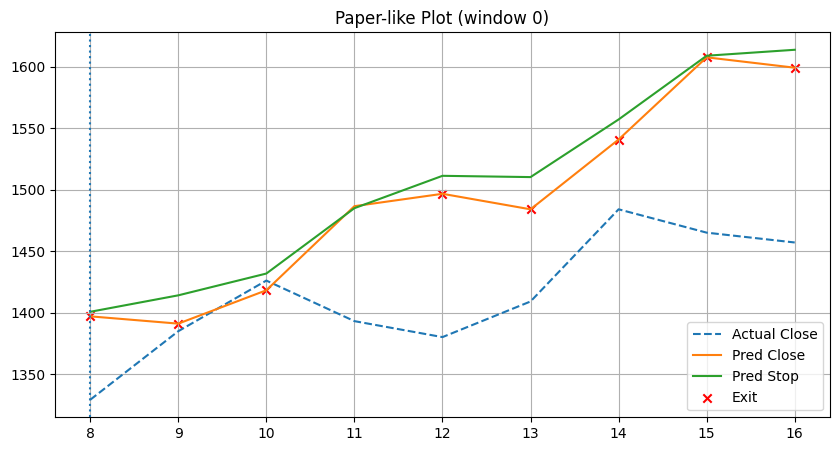

In [540]:
def inverse(col, arr):
    idx = scale_cols.index(col)
    dummy = np.zeros((len(arr), len(scale_cols)))
    dummy[:, idx] = arr
    return scaler.inverse_transform(dummy)[:, idx]


def plot_window(window_id=0):
    start = window_id * TRADE_WINDOW
    end = start + TRADE_WINDOW + LOOKBACK
    dfw = df_val.iloc[start:end].reset_index(drop=True)

    Xt = dfw[trend_disc_cols].values.astype(np.float32)
    Xp = dfw[price_cols].values.astype(np.float32)
    Cl = dfw["Close"].values

    pc, ps, act, idxs = [], [], [], []

    trend_model.eval()
    price_model.eval()
    stop_model.eval()

    for t in range(LOOKBACK, len(dfw) - 1):
        xt = torch.from_numpy(Xt[t-LOOKBACK:t]).unsqueeze(0).to(DEVICE)
        xp = torch.from_numpy(Xp[t-LOOKBACK:t]).unsqueeze(0).to(DEVICE)

        # Trend prediction
        tp = torch.sigmoid(trend_model(xt))            # (1,)

        # Price prediction + encoder sequence
        p, enc_out = price_model(xp, return_enc=True)  # p:(1,), enc_out:(1,T,H)

        B, T, H = enc_out.shape

        # Build stop input: enc_out + [p, tp]
        extra = torch.stack([p, tp], dim=1)            # (1,2)
        extra = extra[:, None, :].repeat(1, T, 1)      # (1,T,2)

        x_stop = torch.cat([enc_out, extra], dim=2)    # (1,T,H+2)

        s = stop_model(x_stop)                          # (1,)

        pc.append(p.item())
        ps.append(s.item())
        act.append(Cl[t+1])
        idxs.append(t+1)

    pc = inverse("Close", np.array(pc))
    ps = inverse("stop_price", np.array(ps))
    act = inverse("Close", np.array(act))

    plt.figure(figsize=(10,5))
    plt.plot(idxs, act, "--", label="Actual Close")
    plt.plot(idxs, pc, label="Pred Close")
    plt.plot(idxs, ps, label="Pred Stop")
    print("Sanity @ first point:",
      "pc", pc[0], "ps", ps[0], "ps>pc", ps[0] > pc[0])


    cross = ps > pc
    if cross.any():
        exit_pos = int(np.where(cross)[0][0])
        plt.scatter(np.array(idxs)[cross], pc[cross],
                    color="red", marker="x", label="Exit")
        plt.axvline(np.array(idxs)[cross][0], linestyle=":")
        print(f"EXIT at idx={idxs[exit_pos]}: pc={pc[exit_pos]:.2f}, ps={ps[exit_pos]:.2f}, ps>pc={ps[exit_pos] > pc[exit_pos]}")
        
    # cross = ps > pc

    # exit_pos = None
    # if cross.any():
    #     exit_pos = int(np.where(cross)[0][0])

    # if exit_pos is not None:
    #     # show both values at exit to avoid confusion
    #     plt.scatter(idxs[exit_pos], pc[exit_pos], color="red", marker="x", s=90, label="Exit@Close")
    #     plt.scatter(idxs[exit_pos], ps[exit_pos], color="red", marker="o", s=40, label="Exit@Stop")
    #     plt.axvline(idxs[exit_pos], linestyle=":", color="red", alpha=0.9)

    #     print(f"EXIT at idx={idxs[exit_pos]}: pc={pc[exit_pos]:.2f}, ps={ps[exit_pos]:.2f}, ps>pc={ps[exit_pos] > pc[exit_pos]}")

    plt.legend()
    plt.grid(True)
    plt.title(f"Paper-like Plot (window {window_id})")
    plt.show()



plot_window(0)


Sanity @ first point: pc 1554.7411344498396 ps 1600.987588226272 ps>pc True
EXIT at idx=8: pc=1554.74, ps=1600.99, ps>pc=True


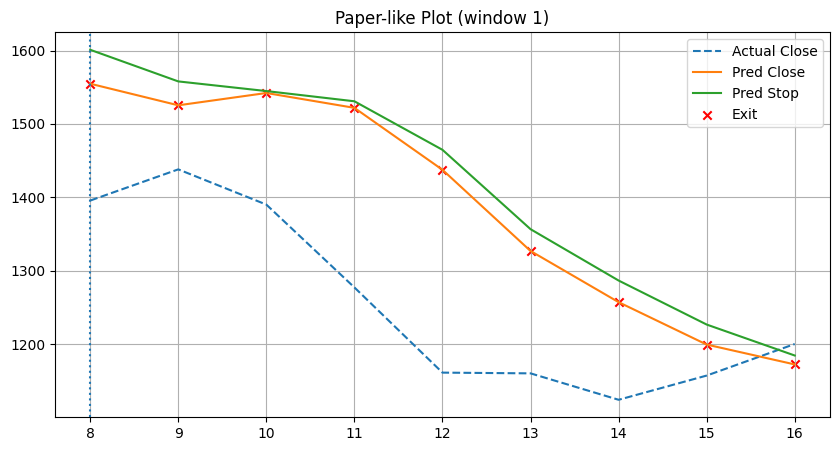

In [541]:
plot_window(1)

Sanity @ first point: pc 1159.9260267019272 ps 1150.207299558489 ps>pc False
EXIT at idx=14: pc=1176.11, ps=1179.00, ps>pc=True


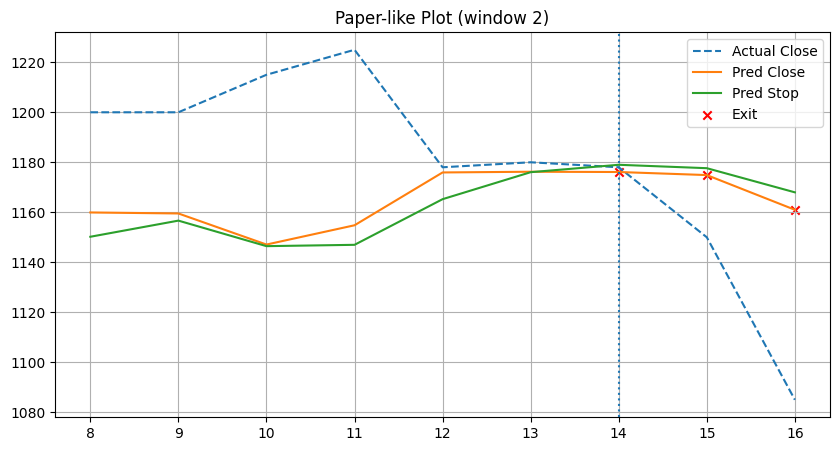

In [543]:
plot_window(2)

In [396]:
@torch.no_grad()
def plot_window_simple(window_id=0):
    start = window_id * TRADE_WINDOW
    end = start + TRADE_WINDOW + LOOKBACK
    dfw = df_val.iloc[start:end].reset_index(drop=True)

    Xt = dfw[trend_disc_cols].values.astype(np.float32)
    Xp = dfw[price_cols].values.astype(np.float32)
    Cl = dfw["Close"].values

    pc, ps, act, idxs = [], [], [], []

    trend_model.eval()
    price_model.eval()
    stop_model.eval()

    for t in range(LOOKBACK, len(dfw) - 1):
        xt = torch.from_numpy(Xt[t-LOOKBACK:t]).unsqueeze(0).to(DEVICE)
        xp = torch.from_numpy(Xp[t-LOOKBACK:t]).unsqueeze(0).to(DEVICE)

        # Trend + price prediction
        tp = torch.sigmoid(trend_model(xt))
        p, enc_out = price_model(xp, return_enc=True)

        # Build stop input: encoder output + [pred_price, pred_trend]
        B, T, H = enc_out.shape
        extra = torch.stack([p, tp], dim=1).unsqueeze(1).repeat(1, T, 1)
        x_stop = torch.cat([enc_out, extra], dim=2)

        s = stop_model(x_stop)

        pc.append(p.item())
        ps.append(s.item())
        act.append(Cl[t+1])
        idxs.append(t+1)

    # Inverse scaling for plotting
    pc = inverse("Close", np.array(pc))
    ps = inverse("stop_price", np.array(ps))
    act = inverse("Close", np.array(act))

    # ---- Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(idxs, act, "--", label="Actual Close")
    plt.plot(idxs, pc, label="Pred Close")
    plt.plot(idxs, ps, label="Pred Stop")
    plt.grid(True)
    plt.legend()
    plt.title(f"Predicted Close vs Stop (window {window_id})")
    plt.show()


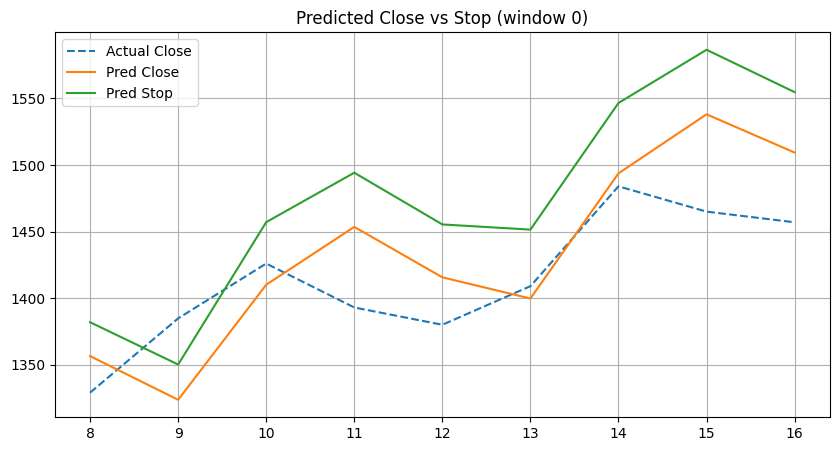

In [397]:
plot_window_simple(0)

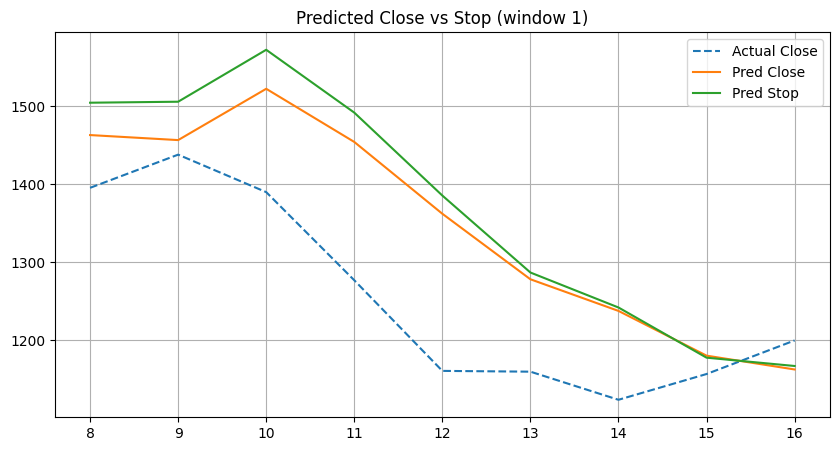

In [398]:
plot_window_simple(1)

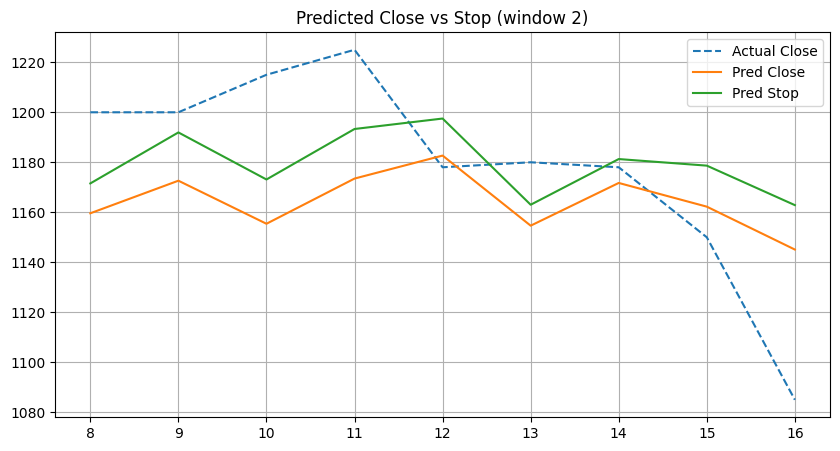

In [399]:
plot_window_simple(2)

In [544]:
def inverse(col, arr, scaler, scale_cols):
    idx = scale_cols.index(col)
    dummy = np.zeros((len(arr), len(scale_cols)))
    dummy[:, idx] = np.asarray(arr)
    return scaler.inverse_transform(dummy)[:, idx]


In [545]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_date_range(
    df,
    start_date,
    end_date,
    date_col="Date",          # or None if datetime index
    trend_disc_cols=None,
    price_cols=None,
    trend_model=None,
    price_model=None,
    stop_model=None,
    scaler=None,
    scale_cols=None,
    lookback=14,
    device="cpu",
    title="Actual vs Predicted Close & Stop",
):
    """
    Plot Actual Close, Predicted Close, Predicted Stop over a date range.

    start_date / end_date: strings or pd.Timestamp
      e.g. "2022-01-01", "2022-03-31"
    """

    # --- Filter by date ---
    if date_col is None:
        df_range = df.loc[start_date:end_date].copy()
    else:
        df_range = df[
            (df[date_col] >= pd.to_datetime(start_date)) &
            (df[date_col] <= pd.to_datetime(end_date))
        ].copy()

    df_range = df_range.reset_index(drop=True)

    if len(df_range) <= lookback:
        raise ValueError("Date range too short for given LOOKBACK")

    # --- Prepare arrays ---
    Xt = df_range[trend_disc_cols].values.astype(np.float32)
    Xp = df_range[price_cols].values.astype(np.float32)
    Cl = df_range["Close"].values
    dates = (
        df_range[date_col].values if date_col is not None else df_range.index.values
    )

    pc, ps, act, plot_dates = [], [], [], []

    trend_model.eval()
    price_model.eval()
    stop_model.eval()

    # --- Rolling prediction ---
    for t in range(lookback, len(df_range)):
        xt = torch.from_numpy(Xt[t-lookback:t]).unsqueeze(0).to(device)
        xp = torch.from_numpy(Xp[t-lookback:t]).unsqueeze(0).to(device)

        # Trend & price prediction
        pred_trend = torch.sigmoid(trend_model(xt))           # (1,)
        pred_close, enc_out = price_model(xp, return_enc=True)  # (1,), (1,T,H)

        B, T, H = enc_out.shape
        extra = torch.stack([pred_close, pred_trend], dim=1)
        extra = extra[:, None, :].repeat(1, T, 1)

        x_stop = torch.cat([enc_out, extra], dim=2)
        pred_stop = stop_model(x_stop)

        pc.append(pred_close.item())
        ps.append(pred_stop.item())
        act.append(Cl[t])
        plot_dates.append(dates[t])

    # --- Inverse scaling ---
    pc = inverse("Close", np.array(pc), scaler, scale_cols)
    ps = inverse("stop_price", np.array(ps), scaler, scale_cols)
    act = inverse("Close", np.array(act), scaler, scale_cols)

    # --- Plot ---
    plt.figure(figsize=(14, 6))
    plt.plot(plot_dates, act, "--", label="Actual Close", alpha=0.7)
    plt.plot(plot_dates, pc, label="Predicted Close")
    plt.plot(plot_dates, ps, label="Predicted Stop")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [546]:
plot_date_range(
    df=df_val,
    start_date="2023-01-01",
    end_date="2023-01-31",
    date_col="Date",
    trend_disc_cols=trend_disc_cols,
    price_cols=price_cols,
    trend_model=trend_model,
    price_model=price_model,
    stop_model=stop_model,
    scaler=scaler,
    scale_cols=scale_cols,
    lookback=LOOKBACK,
    device=DEVICE,
    title="January 2023 – Actual vs Predicted Close & Stop",
)


KeyError: 'Date'